## Importing Dependencices

In [55]:
import pandas as pd
import os
import shutil
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

## Creating Base Directories

In [9]:
parasitized_dir = Path('malaria_yolo_folder','data', 'raw', 'Parasitized')
annotations_dir = Path('malaria_yolo_folder','annotations')
yolo_dir = Path('malaria_yolo_folder','data', 'raw', 'malaria_cells')
images_out = yolo_dir / 'images'
labels_out = yolo_dir / 'labels'

In [ ]:
os.path.exists(images_out)

In [ ]:
import os
import xml.etree.ElementTree as ET

def convert_voc_to_yolo(voc_dir, yolo_dir, classes):
    for xml_file in os.listdir(voc_dir):
        if not xml_file.endswith(".xml"):
            continue
        tree = ET.parse(os.path.join(voc_dir, xml_file))
        root = tree.getroot()
        w = int(root.find("size/width").text)
        h = int(root.find("size/height").text)
        yolo_lines = []
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)
            box = obj.find("bndbox")
            x_min = float(box.find("xmin").text)
            y_min = float(box.find("ymin").text)
            x_max = float(box.find("xmax").text)
            y_max = float(box.find("ymax").text)
            x_center = ((x_min + x_max) / 2) / w
            y_center = ((y_min + y_max) / 2) / h
            bw = (x_max - x_min) / w
            bh = (y_max - y_min) / h
            yolo_lines.append(f"{cls_id} {x_center} {y_center} {bw} {bh}\n")
        with open(os.path.join(yolo_dir, xml_file.replace(".xml", ".txt")), "w") as f:
            f.writelines(yolo_lines)

# Example usage
convert_voc_to_yolo(
    voc_dir=annotations,
    yolo_dir=annotations_new,
    classes=["infected"]  # or whatever class name you used
)

In [35]:
annotated_files = [f.replace(".txt", ".png") for f in os.listdir(annotations_dir) if f.endswith(".txt")]

train_files, val_files = train_test_split(annotated_files, test_size=0.2, random_state=2)

def copy_pairs(files_list, split):
    for file in files_list:
        img_src = parasitized_dir / file
        label_src = annotations_dir / file.replace('.png', '.txt')
        img_dst = images_out / split / file
        label_dst = labels_out / split / file.replace('.png', '.txt')
        os.makedirs(os.path.dirname(img_dst), exist_ok = True)
        os.makedirs(os.path.dirname(label_dst), exist_ok = True)
        if os.path.exists(img_src) and os.path.exists(label_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(label_src, label_dst)

In [40]:
copy_pairs(train_files, 'train')
copy_pairs(val_files, 'val')

In [11]:
nih_dataset = Path('NIH-NLM-ThinBloodSmearsPf')
nih_img_out = Path('malaria_yolo_folder','data', 'raw', 'nih_folder', 'nih_imgs')

polygon_set_dir = nih_dataset / 'Polygon Set'

for patient in os.listdir(polygon_set_dir):
    patient_dir = polygon_set_dir / patient
    img_dir = patient_dir / 'img'

    for file in os.listdir(img_dir):
        file_dir = img_dir / file
        shutil.copy(file_dir, nih_img_out)

In [12]:
point_set_dir = nih_dataset / 'Point Set'
for patient in os.listdir(point_set_dir):
    patient_dir = point_set_dir / patient
    img_dir = patient_dir / 'img'

    for file in os.listdir(img_dir):
        file_dir = img_dir / file
        shutil.copy(file_dir, nih_img_out)

In [ ]:
os.listdir(polygon_set_dir)

In [81]:
import os
from pathlib import Path

# === CONFIG ===
SRC_GT = polygon_set_dir
DEST_GT = Path('malaria_yolo_folder','data', 'raw', 'nih_folder', 'nih_annotations')

for patient in os.listdir(SRC_GT):
    gt_path = Path(SRC_GT) / patient / "GT"
    for file in gt_path.glob("*.txt"):
        with open(file, "r") as f:
            lines = f.readlines()[1:]  # skip header

        yolo_lines = []
        for line in lines:
            parts = line.strip().split(",")
            if parts[1] not in ["Parasitized", "Uninfected"]:
                continue
            label = 0 if parts[1] == "Parasitized" else 1
            if parts[3] == "Polygon":
                coords = list(map(float, parts[5:]))
                xs, ys = coords[::2], coords[1::2]
                x_min, x_max = min(xs), max(xs)
                y_min, y_max = min(ys), max(ys)
            else:  # Point
                x, y = map(float, parts[5:7])
                x_min = x_max = x
                y_min = y_max = y

            with open(file.parent / file.name) as f0:
                header = f0.readline().strip().split(',')
            img_w, img_h = float(header[1]), float(header[2])

            x_center = ((x_min + x_max) / 2) / img_w
            y_center = ((y_min + y_max) / 2) / img_h
            w = (x_max - x_min) / img_w
            h = (y_max - y_min) / img_h
            yolo_lines.append(f"{label} {x_center} {y_center} {w} {h}\n")

        out_file = Path(DEST_GT) / file.name
        with open(out_file, "w") as out:
            out.writelines(yolo_lines)

In [ ]:
import os
from pathlib import Path

# === CONFIG ===
SRC_GT = point_set_dir
DEST_GT =  Path('malaria_yolo_folder','data', 'raw', 'nih_folder', 'nih_annotations')

os.makedirs(DEST_GT, exist_ok=True)

for patient in os.listdir(SRC_GT):
    gt_path = Path(SRC_GT) / patient / "GT"
    for file in gt_path.glob("*.txt"):
        with open(file, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split(',')
        img_w, img_h = float(header[1]), float(header[2])

        yolo_lines = []
        for line in lines[1:]:
            parts = line.strip().split(",")
            if parts[1] not in ["Parasitized", "Uninfected"]:
                continue
            label = 0 if parts[1] == "Parasitized" else 1
            x, y = map(float, parts[5:7])

            x_center = x / img_w
            y_center = y / img_h
            w = h = 0.02  # small default box size around point
            yolo_lines.append(f"{label} {x_center} {y_center} {w} {h}\n")

        out_file = Path(DEST_GT) / file.name
        with open(out_file, "w") as out:
            out.writelines(yolo_lines)

In [ ]:
image_list = list(nih_img_out.glob('*.jpg'))
for image in image_list[:5]:
    image = Image.open(image)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

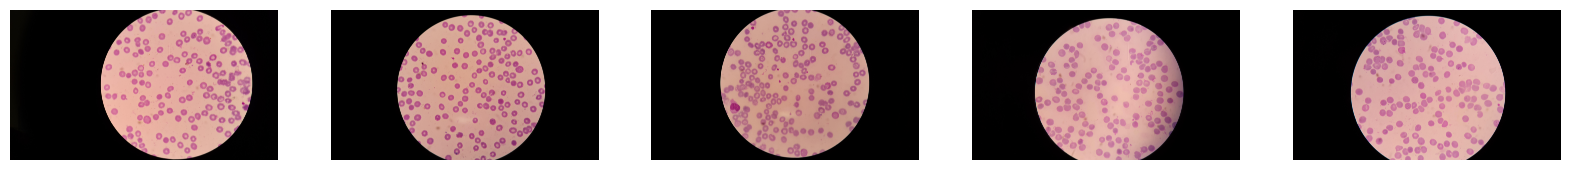

In [36]:
fig, axs = plt.subplots(1, 5, figsize = (20,15))
for i, ax in enumerate(axs):
    ax.imshow(Image.open(image_list[i]))
    ax.axis('off')

In [41]:
DEST_GT = Path('malaria_yolo_folder','data', 'raw', 'nih_folder', 'nih_annotations')
annotated_files = [f.replace(".txt", ".jpg") for f in os.listdir(DEST_GT) if f.endswith(".txt")]

train_files, val_files = train_test_split(annotated_files, test_size=0.2, random_state=2)

def copy_pairs(files_list, split):
    for file in files_list:
        img_src = nih_img_out / file
        label_src = DEST_GT / file.replace('.jpg', '.txt')
        img_dst = images_out / split / file
        label_dst = labels_out / split / file.replace('.jpg', '.txt')
        os.makedirs(os.path.dirname(img_dst), exist_ok = True)
        os.makedirs(os.path.dirname(label_dst), exist_ok = True)
        if os.path.exists(img_src) and os.path.exists(label_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(label_src, label_dst)

copy_pairs(train_files, 'train')
copy_pairs(val_files, 'val')

In [44]:
save_dir = Path('runs', 'detect', 'train2')

In [47]:
os.listdir(save_dir)

['args.yaml',
 'BoxF1_curve.png',
 'BoxPR_curve.png',
 'BoxP_curve.png',
 'BoxR_curve.png',
 'confusion_matrix.png',
 'confusion_matrix_normalized.png',
 'labels.jpg',
 'results.csv',
 'results.png',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'train_batch2.jpg',
 'train_batch2360.jpg',
 'train_batch2361.jpg',
 'train_batch2362.jpg',
 'val_batch0_labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch1_labels.jpg',
 'val_batch1_pred.jpg',
 'val_batch2_labels.jpg',
 'val_batch2_pred.jpg',
 'weights']

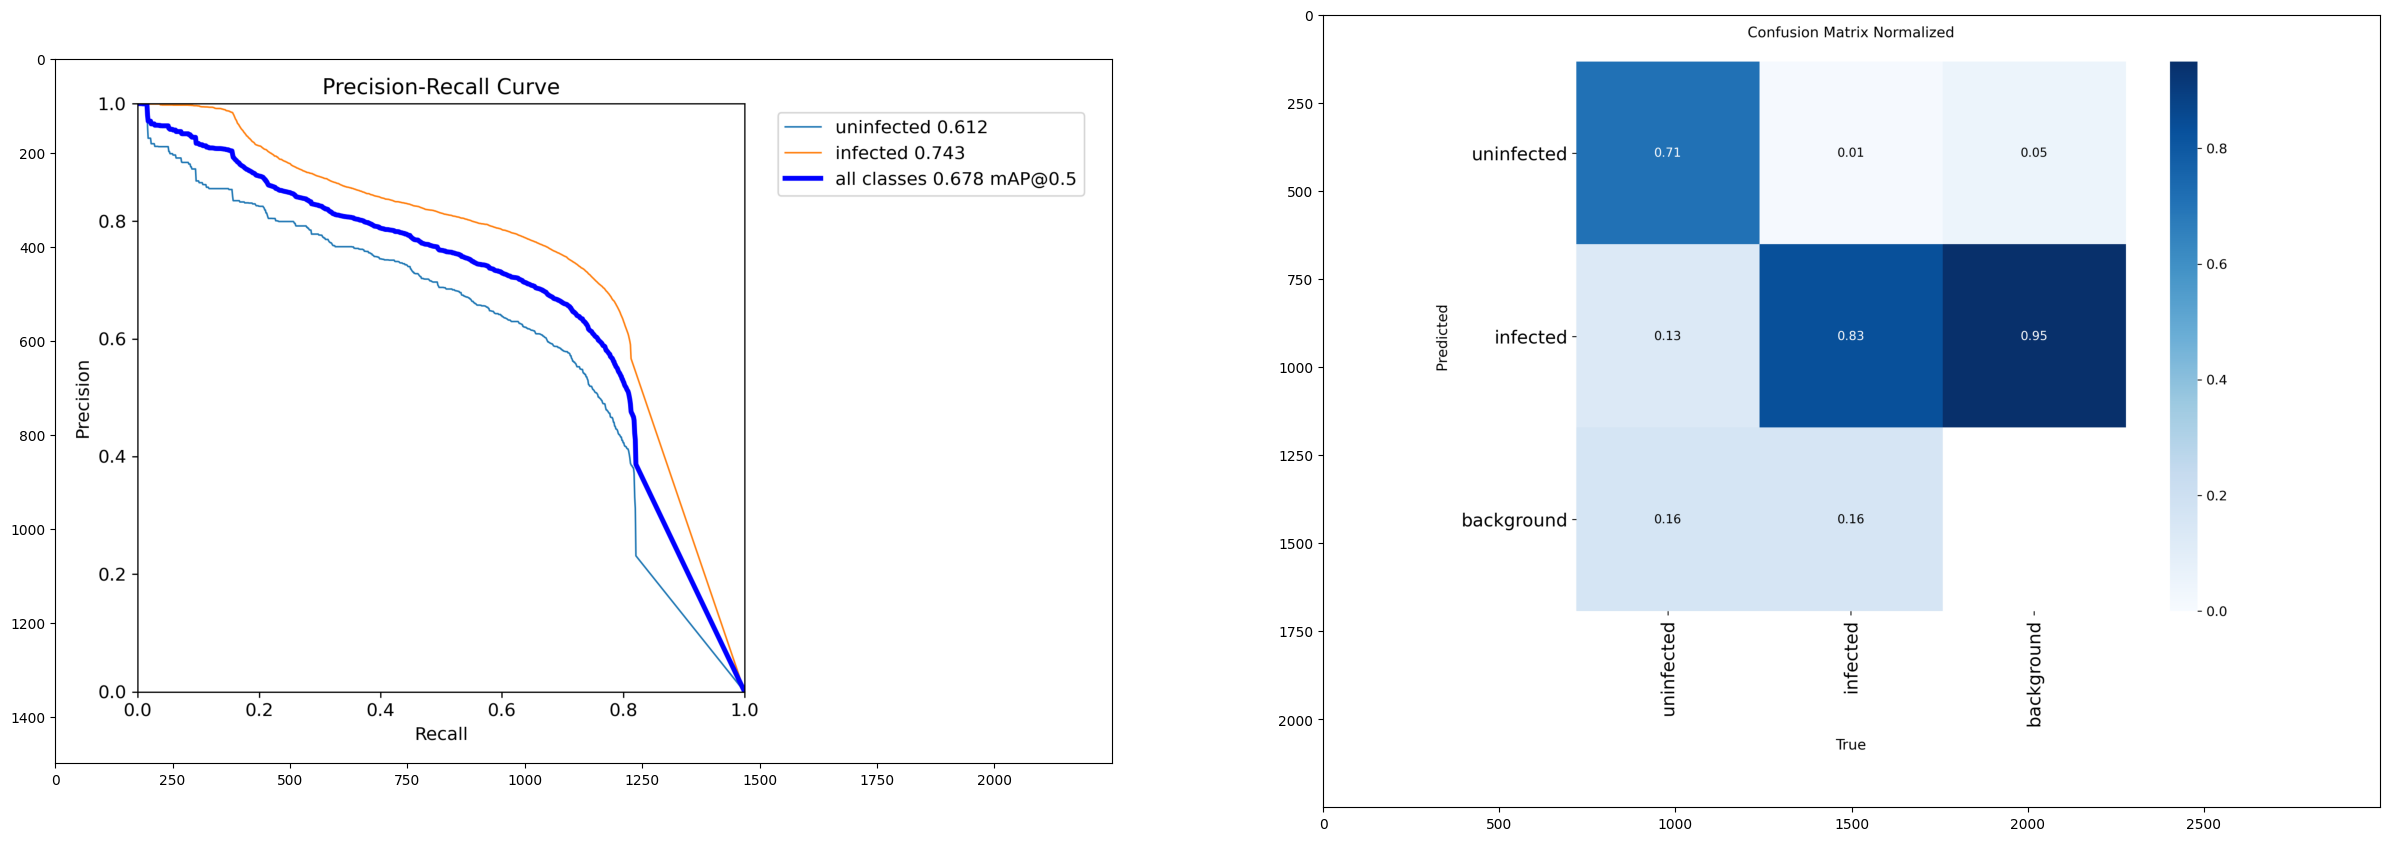

In [54]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (30,20))

image0 = Image.open(save_dir / 'BoxPR_curve.png')
ax0.imshow(image0)

image1 = Image.open(save_dir / 'confusion_matrix_normalized.png')
ax1.imshow(image1)

plt.show()

In [60]:
df = pd.read_csv(save_dir / 'results.csv').set_index('epoch')
df.head()

,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
1,53.4945,3.00732,3.33317,1.09011,0.06843,0.12381,0.04467,0.01300,2.49693,3.56273,1.21857,0.000546,0.000546,0.000546
2,77.1203,2.58933,1.77028,0.93219,0.67053,0.22901,0.14776,0.03674,3.45449,2.33847,1.67448,0.001080,0.001080,0.001080
3,100.5700,2.45001,1.70054,0.91241,0.20936,0.24751,0.14251,0.04124,2.78290,2.59819,1.26123,0.001592,0.001592,0.001592
4,123.9670,2.42776,1.66569,0.90162,0.28145,0.32439,0.24443,0.08051,2.36987,2.51701,1.29236,0.001568,0.001568,0.001568
5,146.9580,2.36292,1.64890,0.90226,0.27497,0.36481,0.26307,0.08398,2.29522,1.83069,1.12788,0.001535,0.001535,0.001535


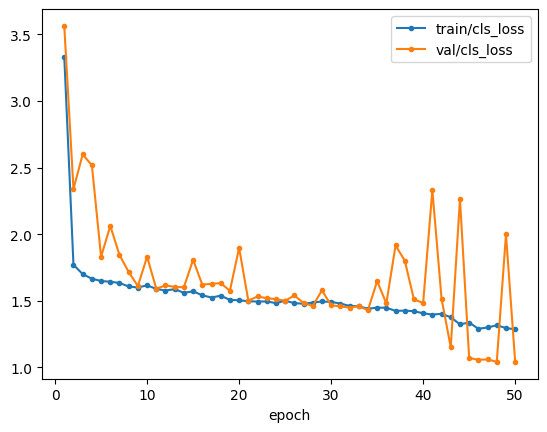

In [65]:
df[['train/cls_loss', 'val/cls_loss']].plot(marker = '.');

In [76]:
import wandb

In [75]:
wandb.init(
    project = 'malaria_parasite_detection',
    name = 'yolov11n-train2',
    config = {
        'epochs':50,
        'imgsz':640,
        'batch':16,
        'cls':0.6,
        'lr':0.001,
        'mosaic':0.7, 
        'hsv_h':0.015, 
        'hsv_s':0.7,
        'hsv_v':0.4,
        'fliplr':0.5,   
        'cache':True,
        'optimizer': 'SGD',
        'device': 'cuda'
    }
)
wandb.config.update(
    {
        'dataset_version': 'malaria_v1.0',
        'experiment_note': 'Baseline YOLOv11n with augmentations and 50 epochs',
        
    }
)

SyntaxError: invalid syntax (118173973.py, line 1)

In [81]:
import csv

results_csv = save_dir / 'results.csv'
if os.path.exists(results_csv):
    with open(results_csv, 'r') as f:
        metrics = csv.read(f)

AttributeError: module 'csv' has no attribute 'read'